## Loading Packages

In [3]:
from Foresight import *
from statsmodels.tsa.arima_process import arma_generate_sample

set_seed(42)

True

### Insuring that training is done on GPU if available

In [4]:
device = 'cpu'

if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
    
    if torch.cuda.device_count() > 1:
        print("Parallel Available")
        parallel=True
        
    else:
        parallel=False
        
else:
    print("No GPU available!")
    parallel=False

No GPU available!


# Multivariate

## Generating Data

Most time series methods would struggle with this data because it is non-stationary. You need to transform it into a stationary signal to analyse

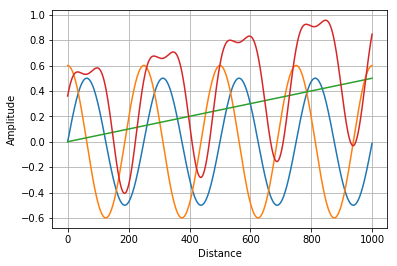

In [5]:
frequency = 4
sample_rate = 1000
x = np.arange(sample_rate)

y_1 = 0.5 * np.sin(2 * np.pi * frequency * x / sample_rate)
y_2 = 0.6 * np.cos(2 * np.pi * frequency * x / sample_rate)
y_3 = 0.0005 * x

target = y_1  + y_2 **2 + y_3

plt.plot(x, y_1, label="Signal 1")
plt.plot(x, y_2, label="Signal 2")
plt.plot(x, y_3, label="Signal 3")
plt.plot(x, target, label="Target")
plt.xlabel('Distance')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

In [6]:
data_X = np.zeros((len(y_1), 3))

data_X[:, 0] = y_1
data_X[:, 1] = y_2
data_X[:, 2] = y_3

### Split into train and target

In [7]:
forecast_length = 5
data_X = data_X[:-forecast_length]
data_y = target[forecast_length:]

data_y = data_y.reshape(len(data_y), 1)

print("Data X shape", data_X.shape,
      "\nData y shape", data_y.shape)

Data X shape (995, 3) 
Data y shape (995, 1)


### Chunking Data

In [8]:
series_length = 60
data_X, data_y = slice_series(data_X, data_y, series_length, dataset_pct=1.0)

# [Number of series, time series length, number of features]
print("Data X shape", data_X.shape,
      "\nData y shape", data_y.shape)

Data X shape (935, 60, 3) 
Data y shape (935, 1)


### Hyperparameters

In [9]:
learning_rate = 1e-2
momentum = 0.5
weight_decay = 1e-4

# Batch Parameters
batch_size = 32

# Training Parameters
n_epochs = 5000
patience = 200
disp_freq= 20
fig_disp_freq= 20


# Model Parameters
num_features = data_X.shape[2]
hidden_dim = 8
dense_hidden = 16
num_layers = 1
output_dim = 1
dropout = 0.0

In [10]:
model = LSTM(num_features=num_features, 
             hidden_dim=hidden_dim,
             dense_hidden=dense_hidden,
             series_length = series_length,
             batch_size=batch_size,
             output_dim=output_dim, 
             num_layers=num_layers, 
             device=device,
             dropout=dropout)

if parallel:
    model = nn.DataParallel(model)
    print("Parallel Workflow\n")
    
model.to(device)

print("num_features %i \nhidden_dim %i\nseries_length %i \nbatch_size %i\noutput_dim %i \nnum_layers %i"
      % (num_features, hidden_dim, series_length, batch_size,output_dim, num_layers))

print('data_X ', data_X.shape, '\ndata_y', data_y.shape)

num_features 3 
hidden_dim 8
series_length 60 
batch_size 32
output_dim 1 
num_layers 1
data_X  (935, 60, 3) 
data_y (935, 1)


In [11]:
optimiser = torch.optim.Adam(model.parameters(), learning_rate)

learning = DeepLearning(model=model, 
                        data_X=data_X, 
                        data_y=data_y, 
                        n_epochs=n_epochs,
                        optimiser=optimiser,
                        batch_size=batch_size,
                        debug=False, 
                        disp_freq=disp_freq,
                        fig_disp_freq=fig_disp_freq, 
                        device=device,
                        patience=patience)

# Splitting the data into the train, validation and test sets
learning.train_val_test()

Epoch: 0 Train: 0.26311 Val: 0.56460  Time: 0.643  Best Val: 0.32358


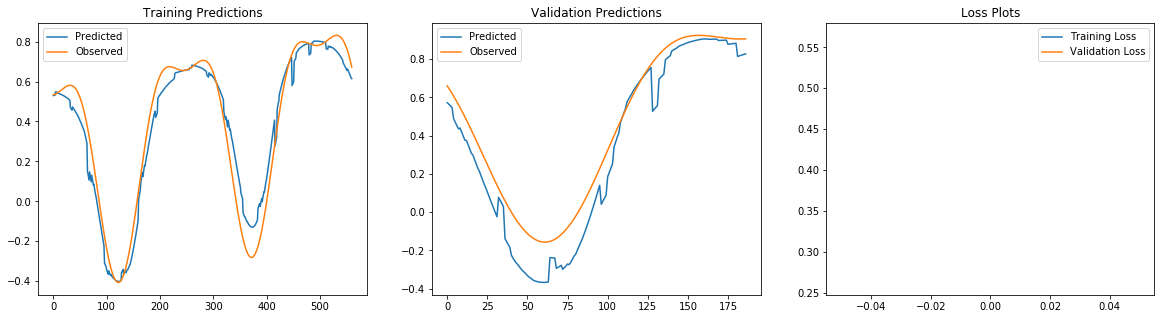

In [13]:
# Allows for continious training by resetting the counters
# learning.disp_freq= 10
# learning.n_epochs = 100
learning.early.stop = False
learning.early.counter = 0
learning.training_wrapper()

### Evaluating on best model

In [14]:
learning.evaluate(learning.best_model, learning.test_loader)

0.4120854081954548

In [15]:
# Observed
train_true = learning.y_train.numpy()
val_true  = learning.y_val.numpy()
test_true  = learning.y_test.numpy()

# Predicted
train_pred = np.array(learning.train_predictions)
val_pred  = np.array(learning.val_predictions)
test_pred = np.array(learning.test_predictions)

### Plotting

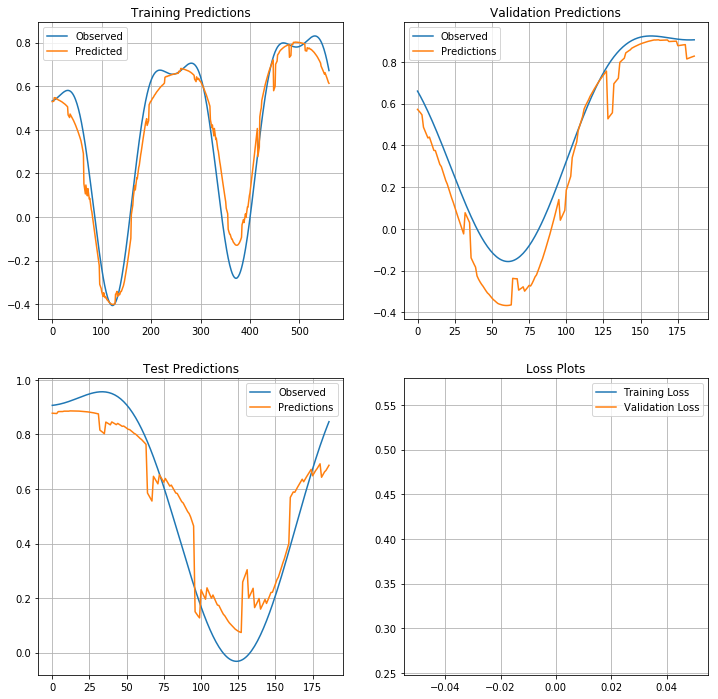

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0, 0].set_title("Training Predictions")
ax[0, 0].plot(train_true, label="Observed")
ax[0, 0].plot(train_pred, label="Predicted")
ax[0, 0].grid()
ax[0, 0].legend()

ax[0, 1].grid()
ax[0, 1].set_title("Validation Predictions")
ax[0, 1].plot(val_true, label="Observed")
ax[0, 1].plot(val_pred, label="Predictions")
ax[0, 1].legend()

ax[1, 0].grid()
ax[1, 0].set_title("Test Predictions")
ax[1, 0].plot(test_true, label="Observed")
ax[1, 0].plot(test_pred, label="Predictions")
ax[1, 0].legend()

ax[1, 1].grid()
ax[1, 1].set_title("Loss Plots")
ax[1, 1].plot(learning.logs['Training Loss'], label="Training Loss")
ax[1, 1].plot(learning.logs['Validation Loss'], label="Validation Loss")
ax[1, 1].legend()

epoch_reached = str(len(learning.logs['Training Loss']))
path = "Results/Plots/"
val_loss = learning.best_val_score

plt.show()

In [17]:
mse, mae, mda = evaluate(test_pred, test_true, log_ret=False)
print("Price Metrics: ", 
      mse, mae, mda)

Price Metrics:  0.01314537586427538 0.09724030722795493 0.7473118279569892


### Comparing to benchmark

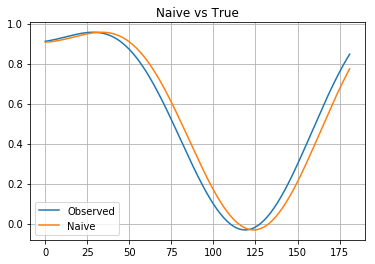

In [19]:
naive_pred = test_true[:-forecast_length]

plt.plot(test_true[forecast_length:] ,label="Observed")
plt.plot(naive_pred, label="Naive")
plt.title("Naive vs True")
plt.grid()
plt.legend()
plt.show()

In [20]:
mse_naive, mae_naive, mda_naive = evaluate(naive_pred, test_true[forecast_length:], log_ret=False)
print("naive",
    mse_naive, mae_naive, mda_naive)

naive 0.0038147385 0.051749565 0.9447513812154696


In [21]:
print("For Mean Squared Error:")

if mse_naive < mse:
    print("Naive Wins")
else:
    print("LSTM Wins")
    
print("For Mean Absolute Error:")

if mae_naive < mae:
    print("Naive Wins")
else:
    print("LSTM Wins")
    
print("For Mean Directional Accuracy:")

if mda_naive > mda:
    print("Naive Wins")
else:
    print("LSTM Wins")

For Mean Squared Error:
Naive Wins
For Mean Absolute Error:
Naive Wins
For Mean Directional Accuracy:
Naive Wins
